In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/allstate-claims-severity/sample_submission.csv
/kaggle/input/allstate-claims-severity/train.csv
/kaggle/input/allstate-claims-severity/test.csv


In [2]:
train = pd.read_csv('../input/allstate-claims-severity/train.csv')
test = pd.read_csv('../input/allstate-claims-severity/test.csv')
sample = pd.read_csv('../input/allstate-claims-severity/sample_submission.csv')

In [3]:
print(train.shape, test.shape, sample.shape)

(188318, 132) (125546, 131) (125546, 2)


In [4]:
train.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6     cont7  \
0   1    A    B    A    B    A    A    A    A    B  ...  0.718367  0.335060   
1   2    A    B    A    A    A    A    A    A    B  ...  0.438917  0.436585   
2   5    A    B    A    A    B    A    A    A    B  ...  0.289648  0.315545   
3  10    B    B    A    B    A    A    A    A    B  ...  0.440945  0.391128   
4  11    A    B    A    B    A    A    A    A    B  ...  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14     loss  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  3005.09  
3  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077  0.602642   939.85  
4  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011  0.432606  2763.85  

[5 rows x 132 columns]

'loss' is our target variable. This is a regression problem.

## EDA and Preprocessing

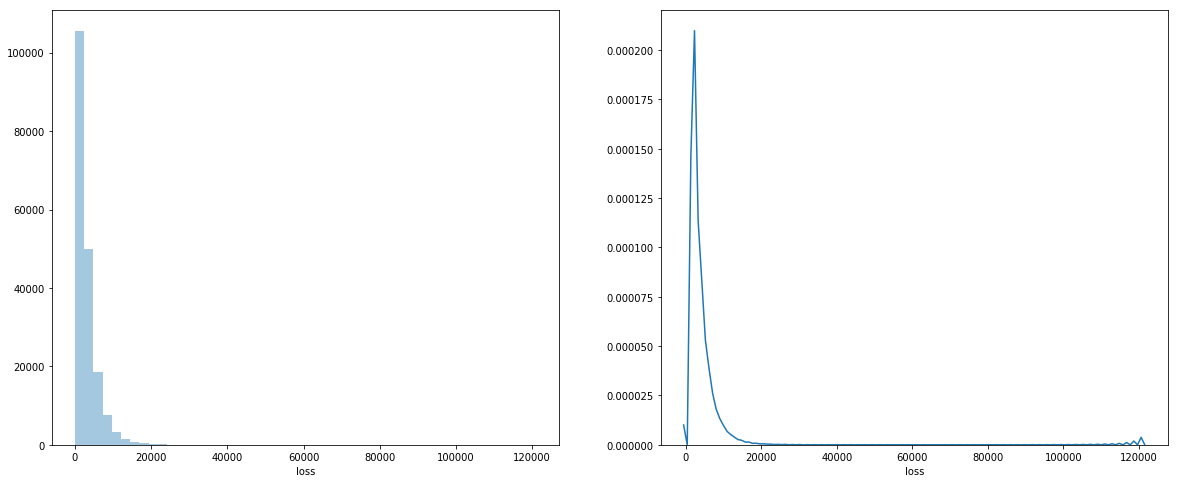

In [5]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
sns.distplot(train['loss'],kde=False, ax=ax[0])
sns.distplot(train['loss'],hist=False, ax=ax[1])

In [6]:
train.dtypes.value_counts()

object     116
float64     15
int64        1
dtype: int64

We have 116 categorical features and 14 numerical features. 

In [7]:
train.isna().any().sum()

0

There are no missing values in the dataset.

In [8]:
train.describe()

id          cont1          cont2          cont3  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean   294135.982561       0.493861       0.507188       0.498918   
std    169336.084867       0.187640       0.207202       0.202105   
min         1.000000       0.000016       0.001149       0.002634   
25%    147748.250000       0.346090       0.358319       0.336963   
50%    294539.500000       0.475784       0.555782       0.527991   
75%    440680.500000       0.623912       0.681761       0.634224   
max    587633.000000       0.984975       0.862654       0.944251   

               cont4          cont5          cont6          cont7  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.491812       0.487428       0.490945       0.484970   
std         0.211292       0.209027       0.205273       0.178450   
min         0.176921       0.281143       0.012683       0.069503   
25%         0.327354       0.281143       0.336105       0.350175   
50%         0.452887       0.422268       0.440945       0.438285   
75%         0.652072       0.643315       0.655021       0.591045   
max         0.954297       0.983674       0.997162       1.000000   

               cont8          cont9         cont10         cont11  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.486437       0.485506       0.498066       0.493511   
std         0.199370       0.181660       0.185877       0.209737   
min         0.236880       0.000080       0.000000       0.035321   
25%         0.312800       0.358970       0.364580       0.310961   
50%         0.441060       0.441450       0.461190       0.457203   
75%         0.623580       0.566820       0.614590       0.678924   
max         0.980200       0.995400       0.994980       0.998742   

              cont12         cont13         cont14           loss  
count  188318.000000  188318.000000  188318.000000  188318.000000  
mean        0.493150       0.493138       0.495717    3037.337686  
std         0.209427       0.212777       0.222488    2904.086186  
min         0.036232       0.000228       0.179722       0.670000  
25%         0.311661       0.315758       0.294610    1204.460000  
50%         0.462286       0.363547       0.407403    2115.570000  
75%         0.675759       0.689974       0.724623    3864.045000  
max         0.998484       0.988494       0.844848  121012.250000

Some insights,
1. For all numerical features, mean value is approx. 0.5 and  standard deviation is approx. 0.2
2. Median values varies from 0.45 to 0.55

Let's plot some numerical features first.

In [9]:
train.corr()

id     cont1     cont2     cont3     cont4     cont5     cont6  \
id      1.000000  0.002130  0.000783  0.000816  0.002578  0.000775  0.001426   
cont1   0.002130  1.000000 -0.085180 -0.445431  0.367549 -0.025230  0.758315   
cont2   0.000783 -0.085180  1.000000  0.455861  0.038693  0.191427  0.015864   
cont3   0.000816 -0.445431  0.455861  1.000000 -0.341633  0.089417 -0.349278   
cont4   0.002578  0.367549  0.038693 -0.341633  1.000000  0.163748  0.220932   
cont5   0.000775 -0.025230  0.191427  0.089417  0.163748  1.000000 -0.149810   
cont6   0.001426  0.758315  0.015864 -0.349278  0.220932 -0.149810  1.000000   
cont7   0.002209  0.367384  0.048187  0.097516 -0.115064 -0.249344  0.658918   
cont8   0.005534  0.361163  0.137468 -0.185432  0.528740  0.009015  0.437437   
cont9   0.001870  0.929912 -0.032729 -0.417054  0.328961 -0.088202  0.797544   
cont10  0.002582  0.808551  0.063526 -0.325562  0.283294 -0.064967  0.883351   
cont11  0.001075  0.596090  0.116824  0.025271  0.120927 -0.151548  0.773745   
cont12  0.000889  0.614225  0.106250  0.006111  0.130453 -0.148217  0.785144   
cont13  0.000442  0.534850  0.023335 -0.418203  0.179342 -0.082915  0.815091   
cont14 -0.004924  0.056688 -0.045584 -0.039592  0.017445 -0.021638  0.042178   
loss   -0.001122 -0.010237  0.141528  0.111053 -0.035831 -0.011355  0.040967   

           cont7     cont8     cont9    cont10    cont11    cont12    cont13  \
id      0.002209  0.005534  0.001870  0.002582  0.001075  0.000889  0.000442   
cont1   0.367384  0.361163  0.929912  0.808551  0.596090  0.614225  0.534850   
cont2   0.048187  0.137468 -0.032729  0.063526  0.116824  0.106250  0.023335   
cont3   0.097516 -0.185432 -0.417054 -0.325562  0.025271  0.006111 -0.418203   
cont4  -0.115064  0.528740  0.328961  0.283294  0.120927  0.130453  0.179342   
cont5  -0.249344  0.009015 -0.088202 -0.064967 -0.151548 -0.148217 -0.082915   
cont6   0.658918  0.437437  0.797544  0.883351  0.773745  0.785144  0.815091   
cont7   1.000000  0.142042  0.384343  0.492621  0.747108  0.742712  0.288395   
cont8   0.142042  1.000000  0.452658  0.336588  0.302381  0.315904  0.476402   
cont9   0.384343  0.452658  1.000000  0.785697  0.608000  0.626656  0.642028   
cont10  0.492621  0.336588  0.785697  1.000000  0.702896  0.713812  0.707876   
cont11  0.747108  0.302381  0.608000  0.702896  1.000000  0.994384  0.466247   
cont12  0.742712  0.315904  0.626656  0.713812  0.994384  1.000000  0.478677   
cont13  0.288395  0.476402  0.642028  0.707876  0.466247  0.478677  1.000000   
cont14  0.022286  0.043539  0.074154  0.041808  0.047293  0.050267  0.047543   
loss    0.119799  0.030508  0.014456  0.020236  0.099806  0.098724 -0.004022   

          cont14      loss  
id     -0.004924 -0.001122  
cont1   0.056688 -0.010237  
cont2  -0.045584  0.141528  
cont3  -0.039592  0.111053  
cont4   0.017445 -0.035831  
cont5  -0.021638 -0.011355  
cont6   0.042178  0.040967  
cont7   0.022286  0.119799  
cont8   0.043539  0.030508  
cont9   0.074154  0.014456  
cont10  0.041808  0.020236  
cont11  0.047293  0.099806  
cont12  0.050267  0.098724  
cont13  0.047543 -0.004022  
cont14  1.000000  0.019298  
loss    0.019298  1.000000

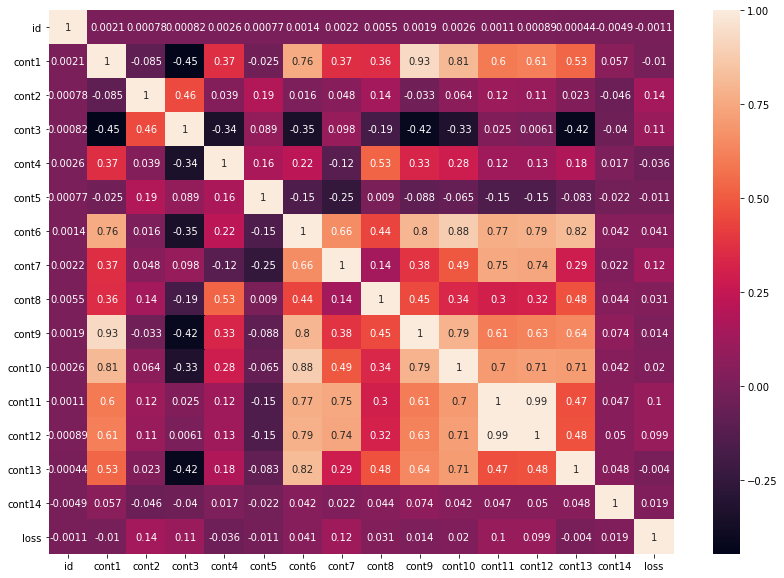

In [10]:
plt.figure(figsize=(14,10))
sns.heatmap(train.corr(), annot=True)

1. cont1 and cont10,cont9 and cont6, cont10 and cont6 are highly correlated.
2. No feature is highly correlated with the 'loss' column.

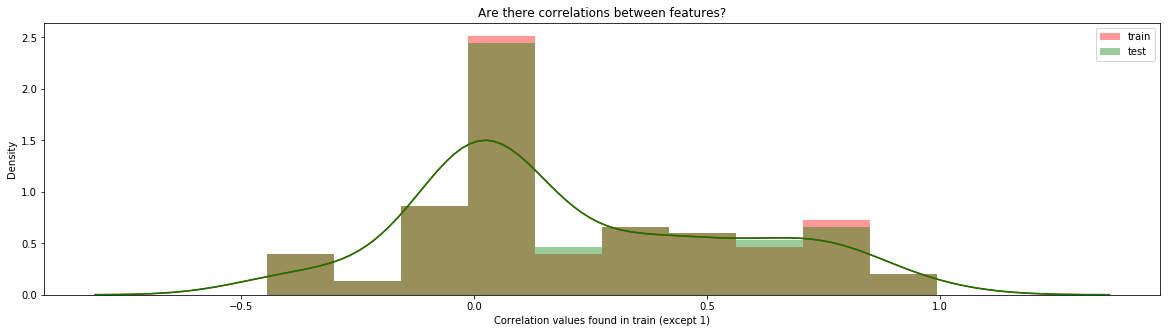

In [11]:
train_correlations = train.drop(["loss"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Are there correlations between features?"); 
plt.legend();

There are some features with correlation values between 0.5 and 1. We need to remove one feature from such highly correlated feature pairs.

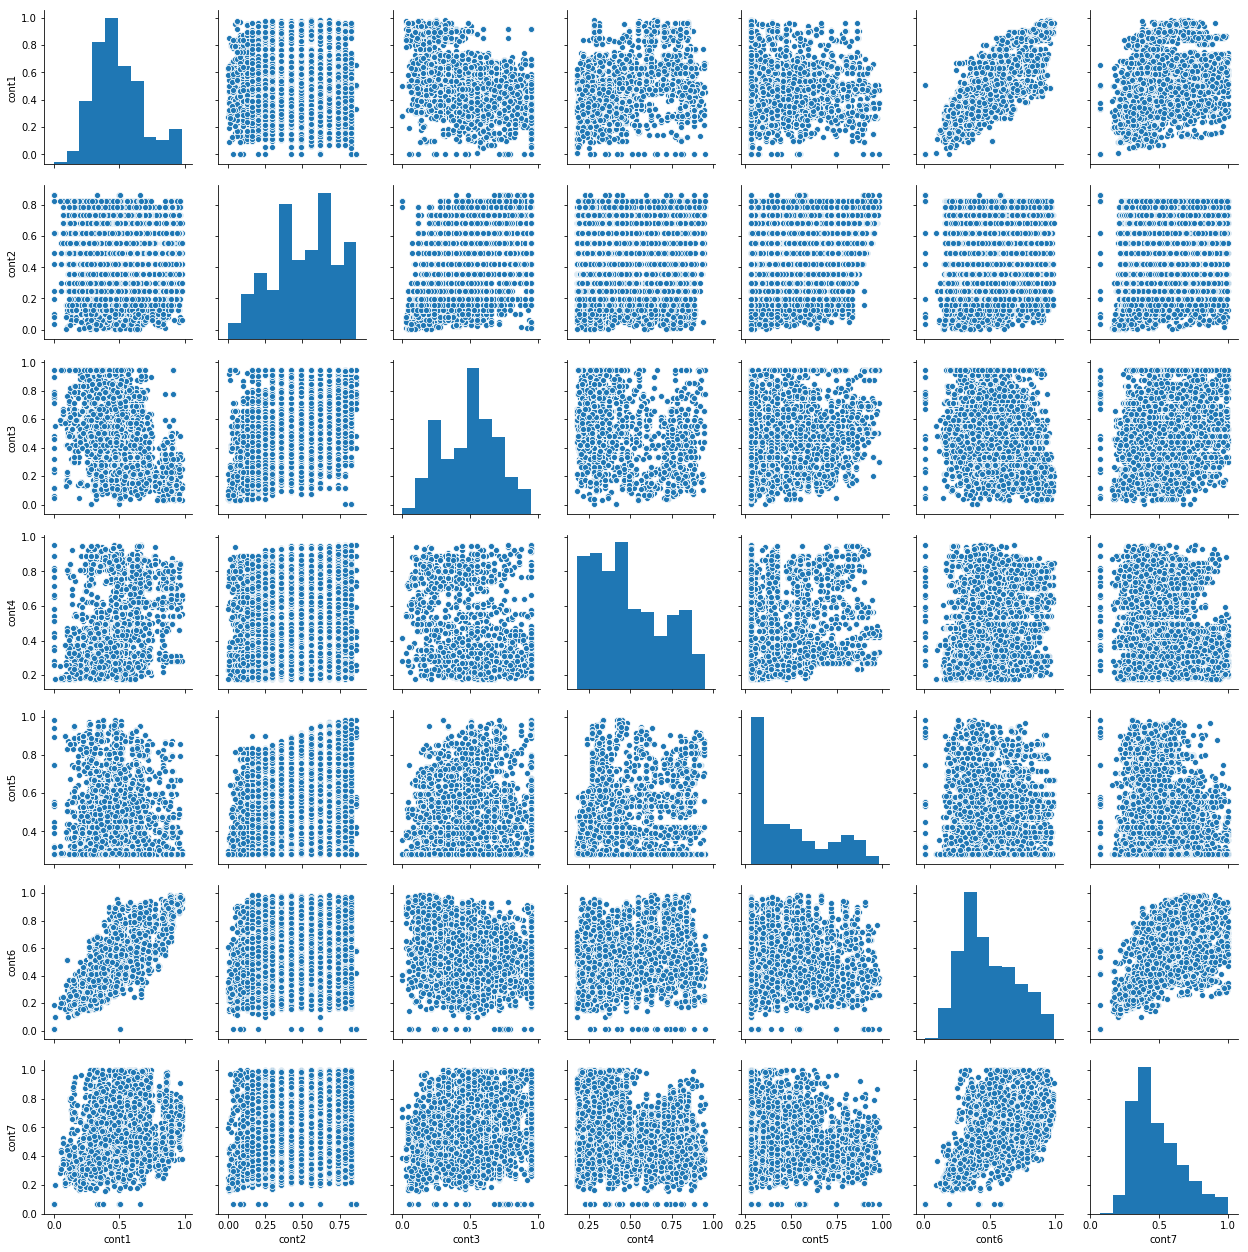

In [12]:
sns.pairplot(train.sample(frac=0.1), vars=['cont1', 'cont2', 'cont3', 'cont4', 'cont5','cont6', 'cont7'])

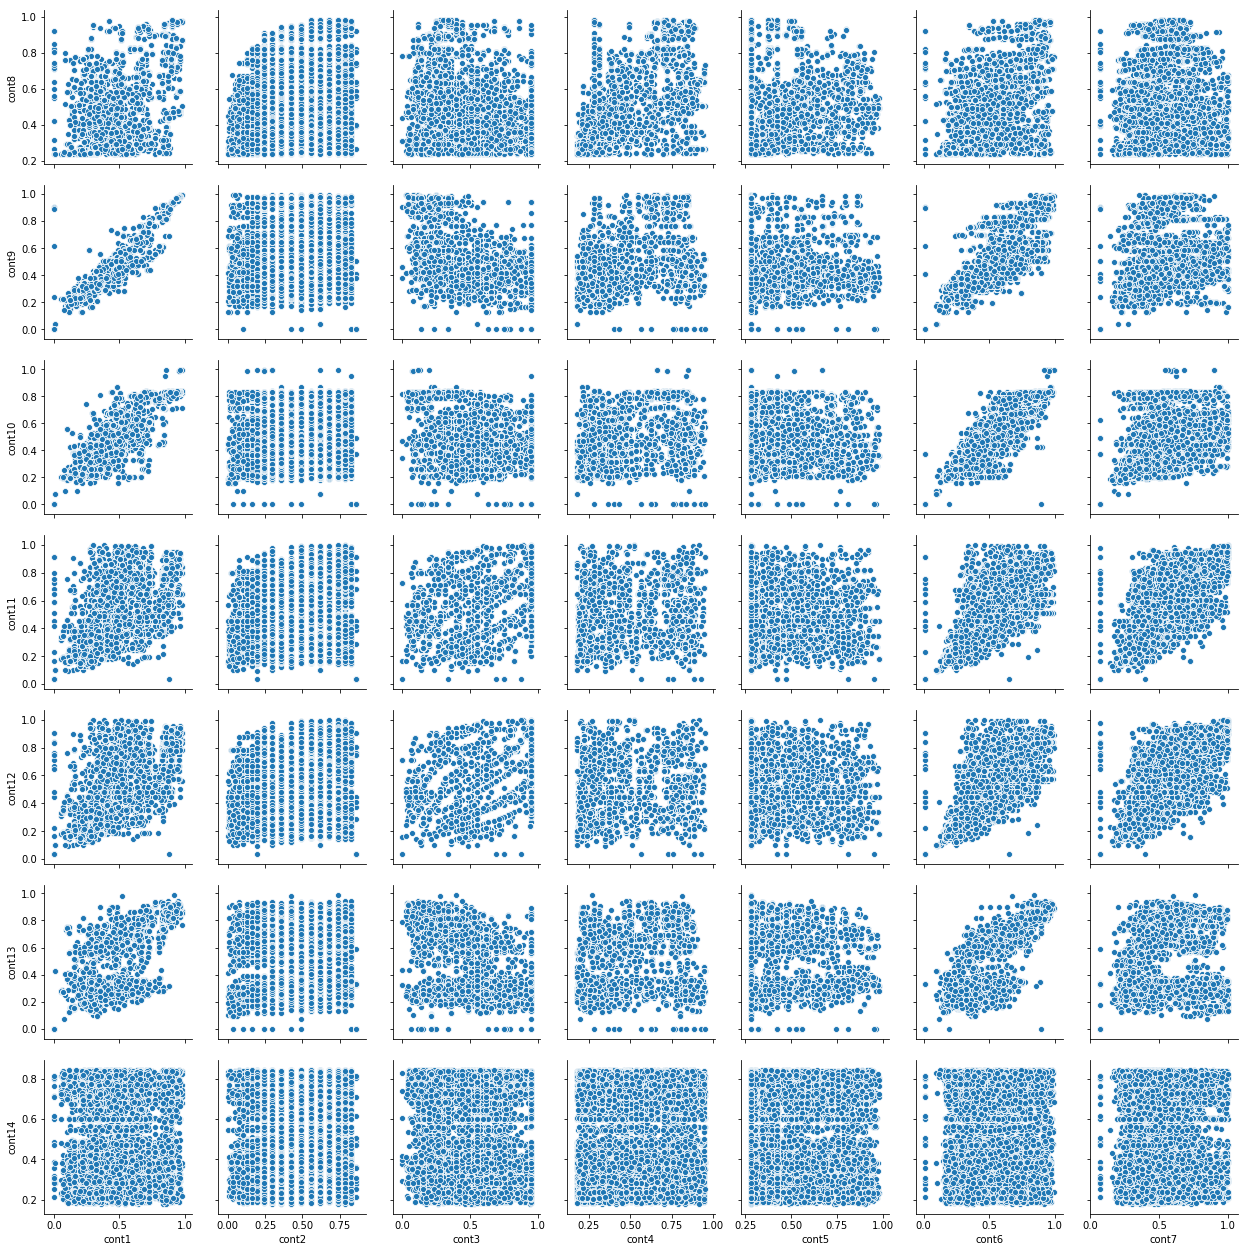

In [13]:
sns.pairplot(train.sample(frac=0.1), x_vars=['cont1', 'cont2', 'cont3', 'cont4', 'cont5','cont6', 'cont7'], y_vars=['cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14'])

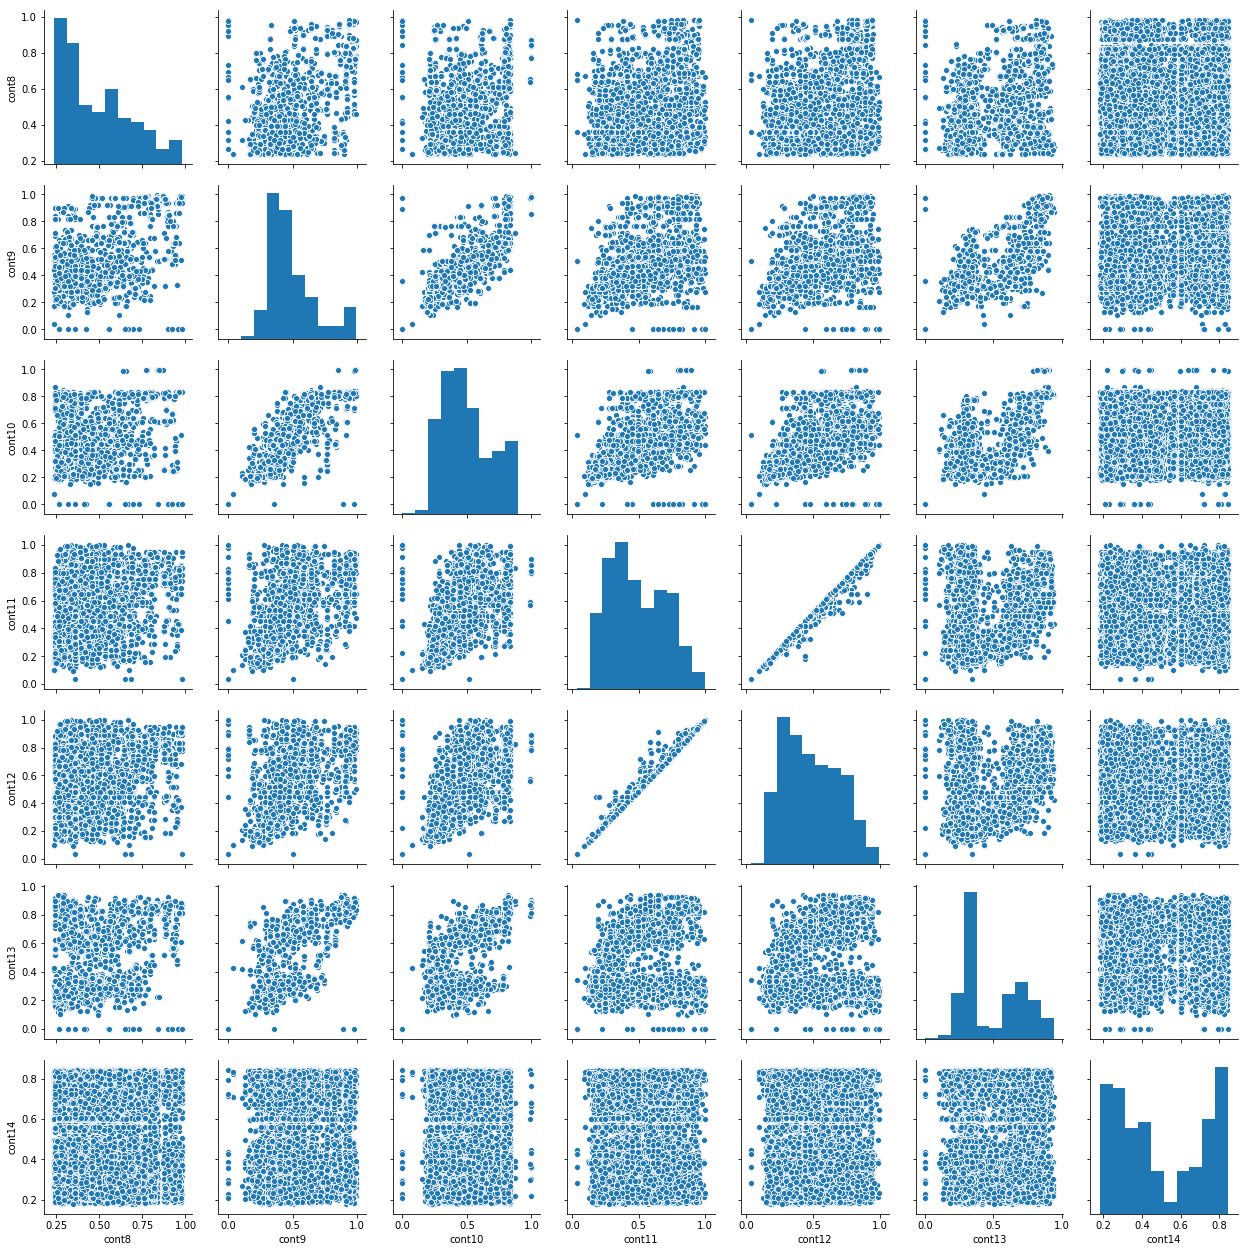

In [14]:
sns.pairplot(train.sample(frac=0.1), vars=['cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14'])

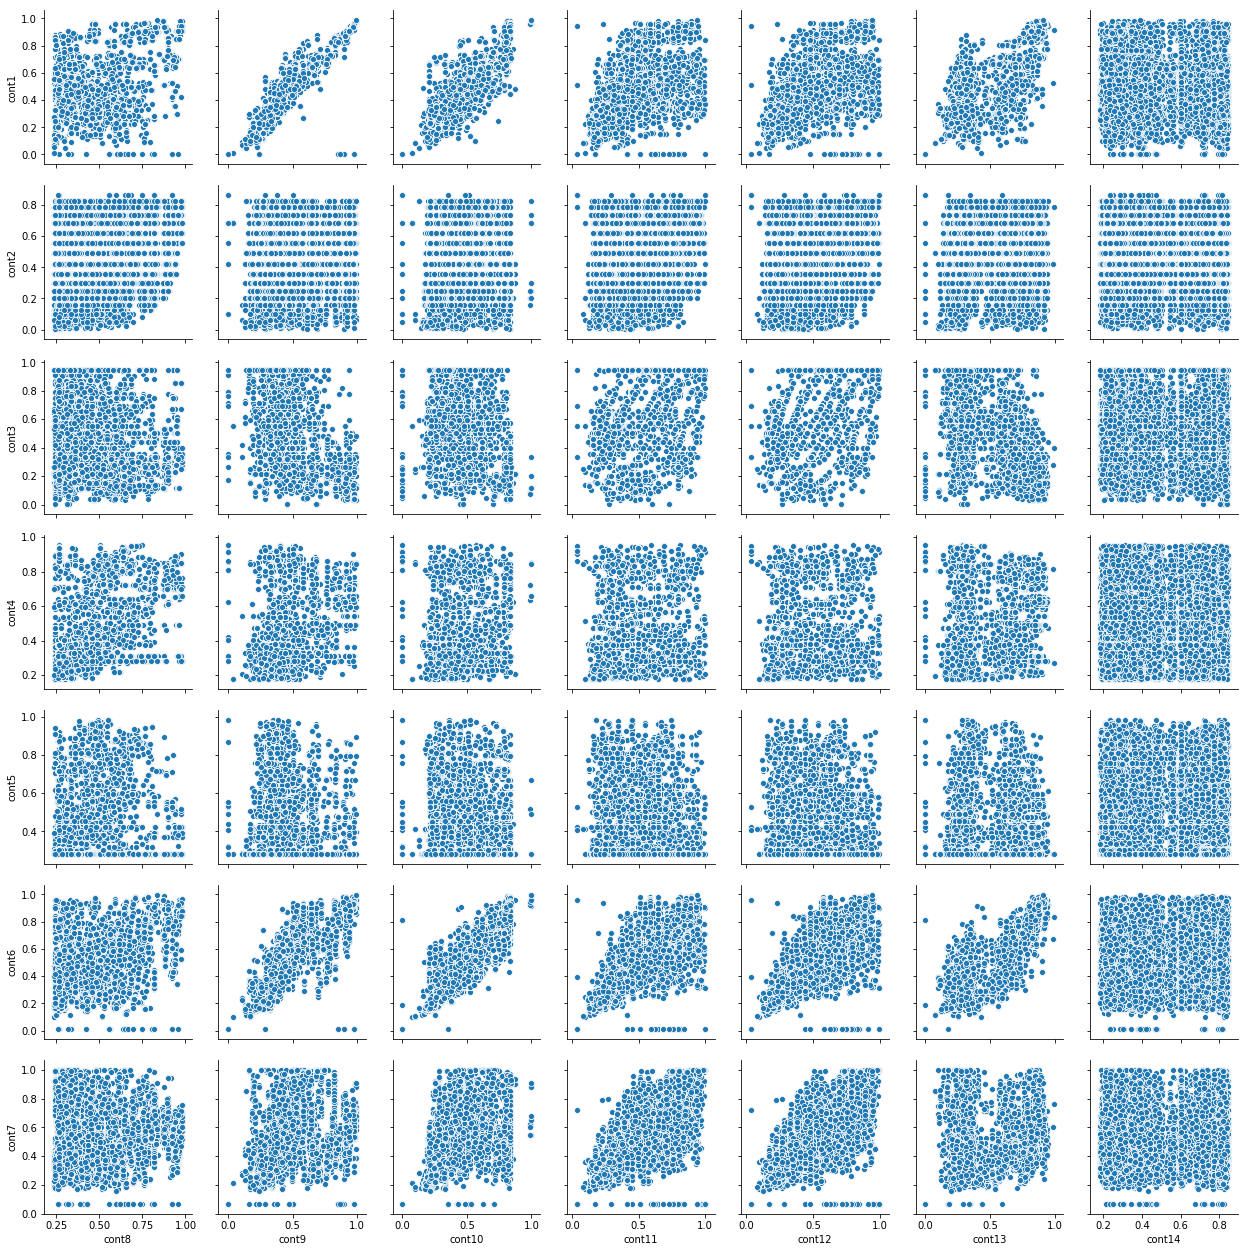

In [15]:
sns.pairplot(train.sample(frac=0.1), x_vars=['cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14'], y_vars=['cont1', 'cont2', 'cont3', 'cont4', 'cont5','cont6', 'cont7'])

Highly correlated features:
1. cont1 and cont9
2. cont11 and cont12
3. cont10 and cont6

Let's remove one from these pairs.

In [16]:
train = train.drop(['cont1', 'cont11', 'cont10'], axis=1)
test = test.drop(['cont1', 'cont11', 'cont10'], axis=1)

Now, the categorical features.

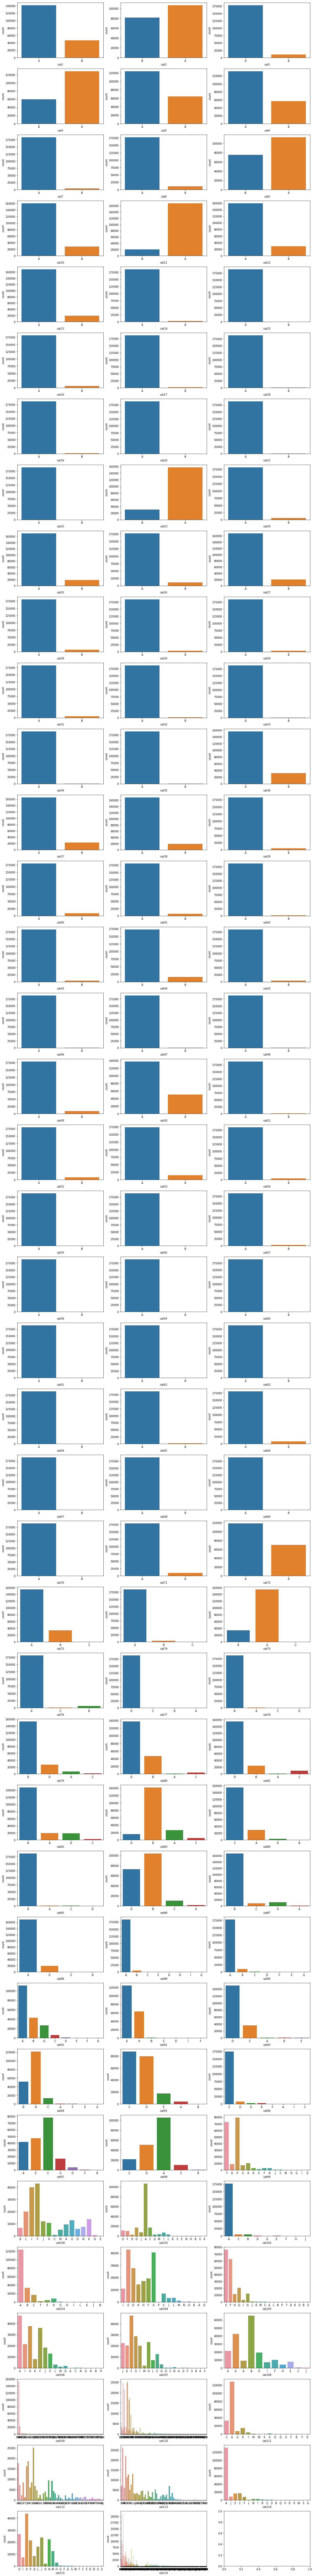

In [17]:
fig,axes = plt.subplots(39,3,figsize=(20,180))
ax = axes.flatten()

for i in range(116):
    sns.countplot(train[f'cat{i+1}'], ax=ax[i])

Insights:
1. 'B' value is rare or less than 'A' in all features.
2. We can bin the features with more than 10 values, but for now let's go with label encoding.

In [18]:
cat_cols = train.select_dtypes(include='object').columns

le = LabelEncoder()

for i in cat_cols:
    test_unique = test[i].unique()
    train_unique = train[i].unique()
    labels = list(set(test_unique) | set(train_unique))
    
    le.fit(labels)
    train[i] = le.transform(train[i])
    test[i] = le.transform(test[i])

## Baseline Submission 

In [19]:
X = train.drop(['loss'], axis=1)
y = np.log(train['loss']+1)

In [20]:
X_train,X_val,y_train, y_val = train_test_split(X,y,test_size=0.1)

model = LGBMRegressor(n_estimators=300, learning_rate=0.1, random_state=123)
model.fit(X_train,y_train)
preds = model.predict(X_val)

print(mean_absolute_error(preds,y_val))

0.4166574930585714


Text(0.5, 1.0, 'LightGBM Features')

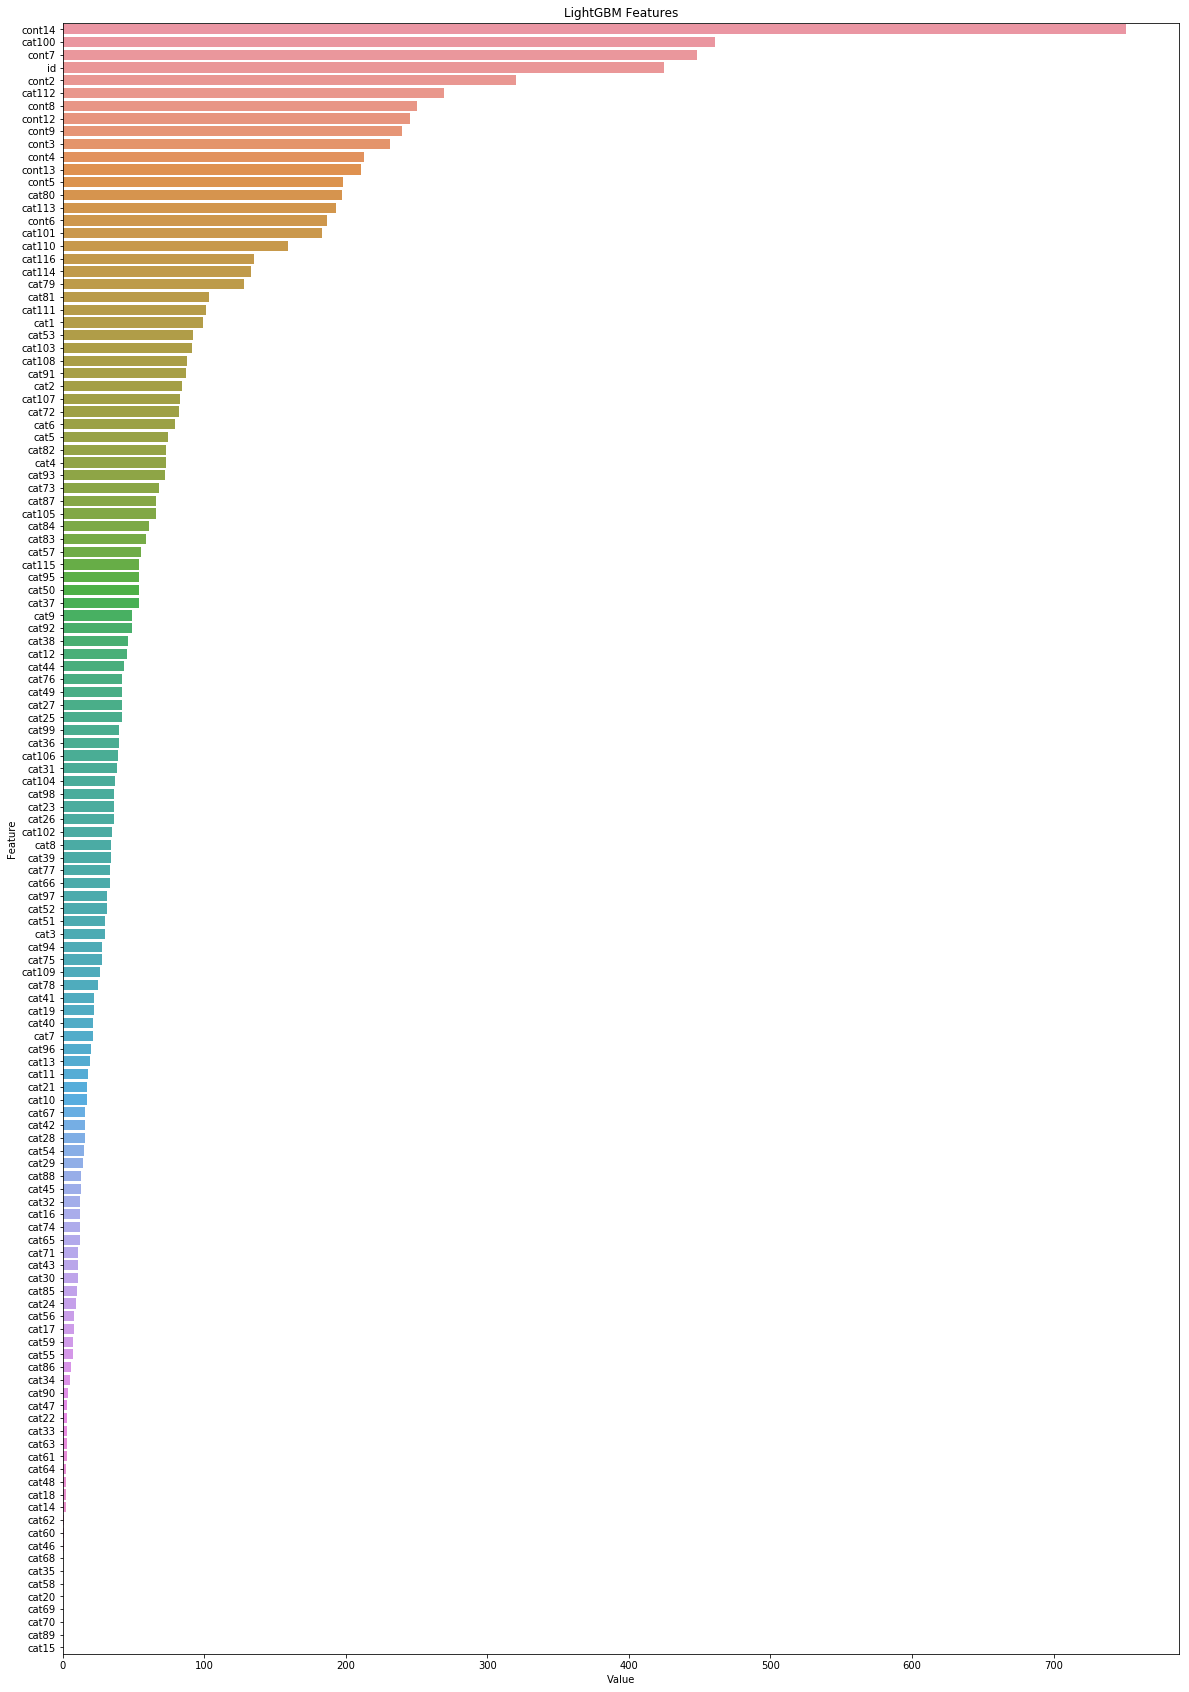

In [21]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

fig,ax = plt.subplots(1,1,figsize=(20,30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), ax=ax)
plt.title('LightGBM Features')

In [22]:
test_predictions = model.predict(test)
sample['loss'] = np.expm1(test_predictions)
sample.to_csv('submission.csv', index=False)

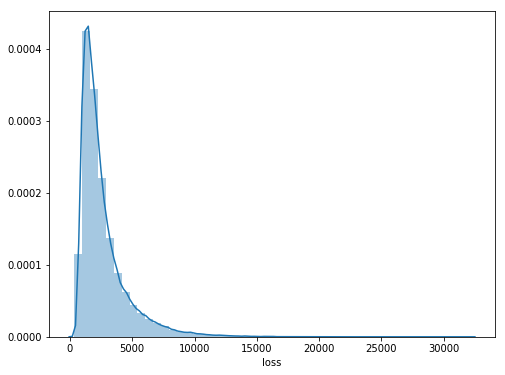

In [23]:
plt.figure(figsize=(8,6))
sns.distplot(sample['loss'])

## References:

1. https://www.kaggle.com/sharmasanthosh/exploratory-study-on-ml-algorithms
Learned a lot from this amazing kernel.